### Отчет по практической работе

**Выполнил**: Лежнин Максим Витальевич (ПМ-31)

**Преподаватель**: Олейник Т.А., кафедра ВМ-1

###### Проектное задание, вариант № **7**

###### Осенний семестр, 2023 год

###### МИЭТ, Зеленоград

### Библиотеки

In [1]:
import numpy as np
import scipy
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn
from math import floor
import random

### Задание
Иван решил проехать из города А в город Б по дороге длиной 700 км на необычном транспортном средстве (далее ТС), движение которого зависит от результатов бросков игральной кости. Условия одного шага передвижения следующие:
- если при броске кости выпадает 1 и 2, то ТС везет Ивана вперед на 4 км;
- если выпадает 3 или 4, то ТС везет Ивана вперед на 1 км;
- если выпадает 5 или 6, то Иван бросает кость повторно и ТС провозит Ивана вперед на расстояние (в км), равное произведению выпавшего числа очков на три.

При достижении города Б ТС Ивана останавливается.

- Путем компьютерного моделирования получите историю передвижения Ивана за 150 шагов и визуализируйте ее (постройте график зависимости удаленности Ивана от города А от номера шага). Повторите моделирование многократно, используя для
визуализации одну систему координат.
- Рассмотрите случайную величину X – число шагов, за которое Иван достигнет города Б. Основываясь на результатах компьютерного моделирования, попробуйте сформулировать гипотезы о законе ее распределения и проверьте их. Оцените вероятность, что за 150 шагов Иван доберется до города Б.
- Постройте доверительные интервалы для математического ожидания и дисперсии случайной величины X.

In [2]:
# класс для представления результата моделирования в красивом виде
class Result:
    def __init__(self, step_list):
        self.step_history = step_list
        self.distance_history = [sum(step_list[:i + 1]) for i in range(len(step_list))]
        self.number_of_steps = len([i for i in step_list if i > 0])
        self.distance = sum(step_list)

# имитация кости
def cube():
    return random.randint(1, 6)

# имитация одного шага (расстояние в километрах за один бросок кости)
def step():
    distance = 0
    way = round((cube() - 1) / 2)

    match way:
        case 0:
            distance += 4
        case 1:
            distance += 1
        case 2:
            distance += cube() * 3

    return distance

# проезд всего пути за указанное количество шагов
# если шагов указано < 0, то едем все указанное расстояние
def run(distance, steps=-1):
    step_list = []
    while distance > 0 and steps != 0:
        step_list.append(step())
        distance -= step_list[-1]
        steps -= 1
    
    if distance < 0: step_list[-1] += distance
        
    while steps > 0:
        step_list.append(0)
        steps -= 1
    
    return Result(step_list)

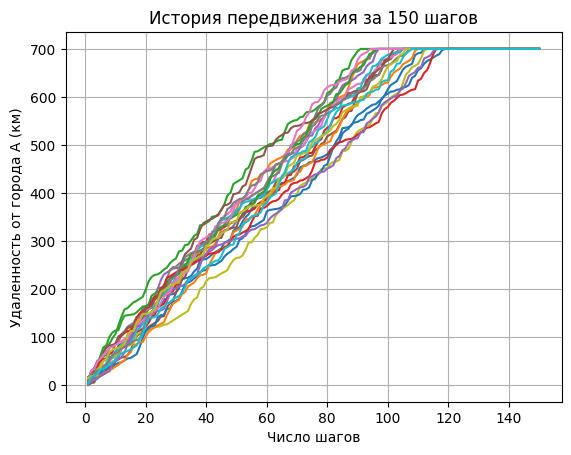

In [3]:
# количество графиков
num_of_iterations = 20

# количество шагов
steps = 150

# расстояние от А до Б
distance = 700

# моделируем поездки и выводим графики
for n in range(num_of_iterations):
    res = run(distance, steps)
    x = np.linspace(1, steps, steps)
    history = res.distance_history
    plt.plot(x, history)

plt.title(f"История передвижения за {steps} шагов")
plt.xlabel("Число шагов")
plt.ylabel("Удаленность от города А (км)")
plt.grid(True)

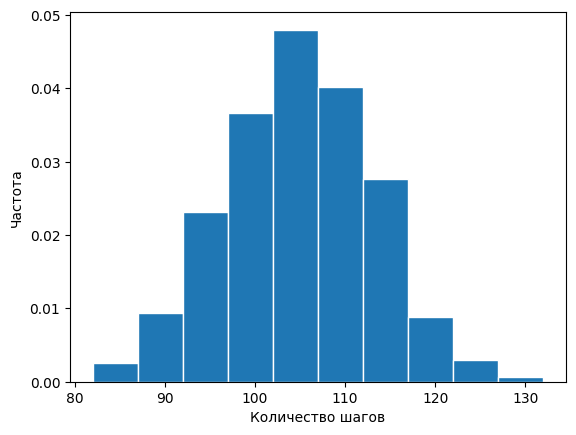

In [4]:
# размер выборки случайной величины X
sample_size = 1000

# выборка X (колиество шагов, за которое Иван доедет до Б)
sample = []

# генерируем выборку
for n in range(sample_size):
    res = run(distance, -1)
    sample.append(res.number_of_steps)

# гистограмма
plt.hist(sample, edgecolor='w', density=True)
plt.xlabel("Количество шагов")
plt.ylabel("Частота");

График похож на плотность вероятности нормального распределения. Проверим с помощью критерия Шапиро.

In [5]:
# получаем p-значение при основной гипотезе о нормальности
# полученной выборки
shapiro_results = sts.shapiro(sample)
print(f"p-значение по Шапиро: {shapiro_results.pvalue}")

p-значение по Шапиро: 0.07202427834272385


При привычных уровнях значимости мы можем считать величину X нормально распределенной. Посчитаем вероятность доехать до пункат Б за 150 шагов.

In [6]:
# оценки мат ожидания и среднеквадратичного отклонения
m = np.mean(sample)
std = np.std(sample)

# предполагаемое распределение
distribution = sts.norm(m, std)

# оценка вероятности события, при котором Иван доедет за 150 шагов
check_step = 150
print("P{X <= 150} =", distribution.cdf(check_step))

P{X <= 150} = 0.9999999898385706


Пусть дан уровень значимости $\alpha$.

Доверительный интервал для математического ожидания при неизвестной дисперсии:
$$\overline{X} - t_{1-\alpha/2}(n - 1) \frac{S}{\sqrt{n}} < m < \overline{X} + t_{1-\alpha/2}(n - 1) \frac{S}{\sqrt{n}}$$

Доверительный интервал для дисперсии при неизвестном математическом ожидании:
$$\frac{(n - 1)S^2}{\chi^2_{1-\alpha/2}(n - 1)} < \sigma < \frac{(n - 1)S^2}{\chi^2_{\alpha/2}(n - 1)}$$

In [7]:
# доверительный интервал для мат ожидания (при неизвестной дисперсии)
def confidence_interval_for_m(sample, alpha):
    n = len(sample)
    S_sq = np.var(sample, ddof=1)
    tmp = sts.t(n - 1).ppf(1 - alpha / 2) * np.sqrt(S_sq / n)
    left_border = np.mean(sample) - tmp
    right_border = np.mean(sample) + tmp
    return (left_border, right_border)

# доверительный интервал для дисперсии (при неизвестном мат ожидании)
def confidence_interval_for_var(sample, alpha):
    n = len(sample)
    S_sq = np.var(sample, ddof=1)
    left_border = (n - 1) * S_sq / (sts.chi2(n - 1).ppf(1 - alpha / 2))
    right_border = (n - 1) * S_sq / (sts.chi2(n - 1).ppf(alpha / 2))
    return (left_border, right_border)

In [8]:
# уровень значимости
alpha = 0.05

# строим интервал для мат ожидания
interval_for_m = confidence_interval_for_m(sample, alpha)
print("Доверительный интервал для мат ожидания")
print(f"({interval_for_m[0]}, {interval_for_m[1]})")
print()


# строим интервал для дисперсии
interval_for_var = confidence_interval_for_var(sample, alpha)
print("Доверительный интервал для дисперсии")
print(f"({interval_for_var[0]}, {interval_for_var[1]})")

Доверительный интервал для мат ожидания
(103.95998501024836, 104.96801498975164)

Доверительный интервал для дисперсии
(60.54523379656111, 72.15879991647601)
